In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import torch
from torch import nn
import torch.nn.functional as F

In [2]:
df = pd.read_csv('Iris.csv')
df.drop('Id',axis=1,inplace=True)
df.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [3]:
df.loc[df.Species=='Iris-setosa', 'species'] = 0
df.loc[df.Species=='Iris-versicolor', 'species'] = 1
df.loc[df.Species=='Iris-virginica', 'species'] = 2
df.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species,species
0,5.1,3.5,1.4,0.2,Iris-setosa,0.0
1,4.9,3.0,1.4,0.2,Iris-setosa,0.0
2,4.7,3.2,1.3,0.2,Iris-setosa,0.0
3,4.6,3.1,1.5,0.2,Iris-setosa,0.0
4,5.0,3.6,1.4,0.2,Iris-setosa,0.0


In [4]:
X = df.iloc[ : , :4].values
X[:5]

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2]])

In [5]:
y = df.iloc[ : , 5].values
y = y.astype('int64')
y[:5]

array([0, 0, 0, 0, 0], dtype=int64)

## SOFTMAX

In [6]:
Sm = nn.Sequential(nn.Linear(4,3))
Sm

Sequential(
  (0): Linear(in_features=4, out_features=3, bias=True)
)

In [7]:
x_train , x_test , y_train , y_test = train_test_split(X , y , test_size=0.20,random_state=4) 

In [8]:
x_train = torch.from_numpy(x_train)
x_test  = torch.from_numpy(x_test)
y_train = torch.from_numpy(y_train)
y_test = torch.from_numpy(y_test)

In [9]:
print(x_train.size())
print(x_test.size())
print(y_train.size())
print(y_test.size())

torch.Size([120, 4])
torch.Size([30, 4])
torch.Size([120])
torch.Size([30])


In [10]:
from torch.utils.data import DataLoader , TensorDataset
train_ds = TensorDataset(x_train, y_train)
train_ds[0:3]

(tensor([[5.4000, 3.0000, 4.5000, 1.5000],
         [4.6000, 3.2000, 1.4000, 0.2000],
         [6.7000, 2.5000, 5.8000, 1.8000]], dtype=torch.float64),
 tensor([1, 0, 2]))

In [11]:
test_ds = TensorDataset(x_test, y_test)
test_ds[0:3]

(tensor([[6.4000, 2.8000, 5.6000, 2.1000],
         [5.7000, 3.8000, 1.7000, 0.3000],
         [7.4000, 2.8000, 6.1000, 1.9000]], dtype=torch.float64),
 tensor([2, 0, 2]))

In [12]:
# Define data loader for train set
batch_size = 30
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

In [13]:
#Define data loader for test set
batch_size = 10
test_dl = DataLoader(test_ds, batch_size, shuffle=False)

In [14]:
learning_rate= 0.01
criterion = nn.CrossEntropyLoss()
opt = torch.optim.SGD(Sm.parameters(), lr=learning_rate)

In [15]:
def mtrain(n_epoch, model, criterion, opt):
    
    N_test = len(test_ds)
    accuracy_list=[]
    loss_list=[]
    
    for epoch in range(n_epoch):
        
        for xb,yb in train_dl:
            model.train()
            # Generate predictions
            pred = model(xb.float())
            loss = criterion(pred, yb.long())
            # Perform gradient descent
            loss.backward()
            opt.step()
            opt.zero_grad()
            loss_list.append(loss.data)
        
        corr = 0
        #Perfom Prediction On Validation Data
        with torch.no_grad():
            for xt, yt in test_dl:
                model.eval()
                z = model(xt.float())
                _, yhat = torch.max(z.data, 1)
                corr += (yhat == yt).sum().item()
        accuracy = corr / N_test
        accuracy_list.append(accuracy)
     
    return accuracy_list, loss_list

In [16]:
acl , lossl = mtrain(1000,Sm, criterion, opt)

In [17]:
pred = Sm(x_test.float())
_, predicted = torch.max(pred.data, 1)
print(accuracy_score(predicted,y_test)*100)

96.66666666666667


In [18]:
predicted

tensor([2, 0, 2, 2, 2, 1, 2, 0, 0, 2, 0, 0, 0, 1, 2, 0, 1, 0, 0, 2, 0, 2, 1, 0,
        0, 0, 0, 0, 0, 2])

In [19]:
y_test

tensor([2, 0, 2, 2, 2, 1, 1, 0, 0, 2, 0, 0, 0, 1, 2, 0, 1, 0, 0, 2, 0, 2, 1, 0,
        0, 0, 0, 0, 0, 2])

## Neural Network

In [20]:
class Net(nn.Module):
    #Initilize The Layers
    def __init__(self,p=0):
        super().__init__()
        
        self.l1 = nn.Linear(4,8)
        self.o1 = nn.ReLU()
        self.l2 = nn.Linear(8,4)
        self.o2 = nn.ReLU()
        self.l3 = nn.Linear(4,3)
        
        
    def forward(self,x):
        x = self.l1(x)   
        x = self.o1(x)   
        x = self.l2(x)   
        x = self.o2(x)
        x = self.l3(x)
        
        return(x)

In [21]:
neural = Net()
neural

Net(
  (l1): Linear(in_features=4, out_features=8, bias=True)
  (o1): ReLU()
  (l2): Linear(in_features=8, out_features=4, bias=True)
  (o2): ReLU()
  (l3): Linear(in_features=4, out_features=3, bias=True)
)

In [22]:
learning_rate1 = 0.01
criterion1 = nn.CrossEntropyLoss()
opt1 = torch.optim.Adam(neural.parameters(), lr=learning_rate1)

In [23]:
acl1 , lossl1 = mtrain(1000, neural, criterion1, opt1)

In [24]:
pred1 = neural(x_test.float())
_, predicted1 = torch.max(pred1.data, 1)
print(accuracy_score(predicted1,y_test)*100)

93.33333333333333


In [25]:
predicted1

tensor([2, 0, 2, 2, 2, 1, 2, 0, 0, 1, 0, 0, 0, 1, 2, 0, 1, 0, 0, 2, 0, 2, 1, 0,
        0, 0, 0, 0, 0, 2])

In [26]:
y_test

tensor([2, 0, 2, 2, 2, 1, 1, 0, 0, 2, 0, 0, 0, 1, 2, 0, 1, 0, 0, 2, 0, 2, 1, 0,
        0, 0, 0, 0, 0, 2])

## Comparing Two Models

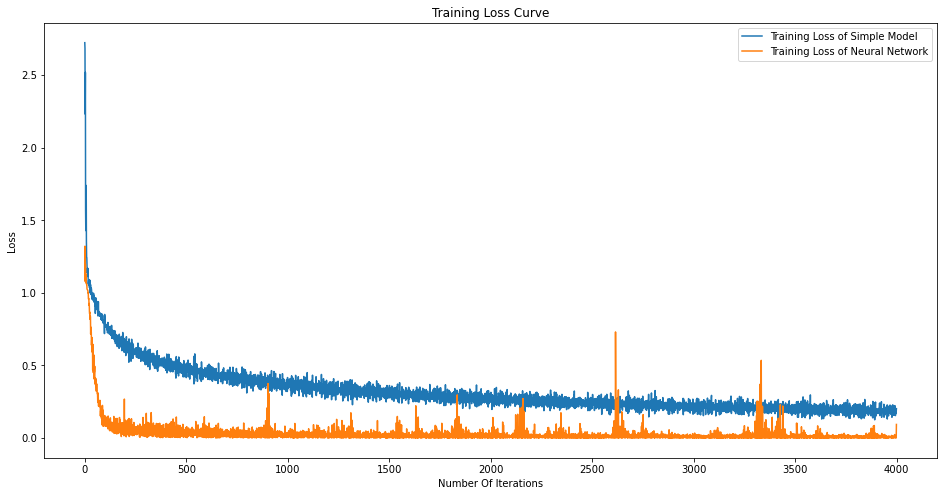

In [27]:
plt.figure(figsize=(16,8))
plt.plot(lossl,label='Training Loss of Simple Model')
plt.plot(lossl1,label='Training Loss of Neural Network')
plt.xlabel('Number Of Iterations')
plt.ylabel('Loss')
plt.title("Training Loss Curve")
plt.legend()

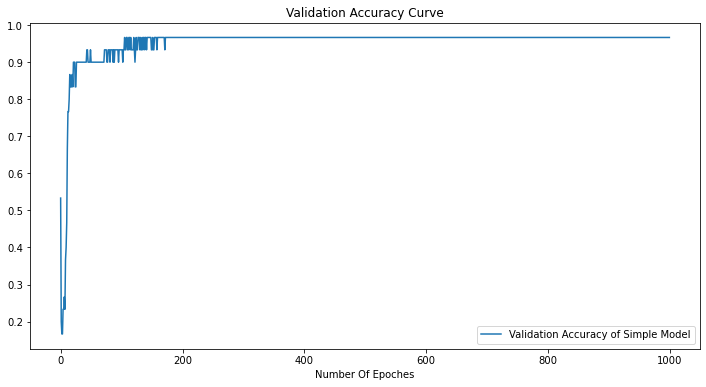

In [28]:
plt.figure(figsize=(12,6))
plt.plot(acl,label='Validation Accuracy of Simple Model')
plt.xlabel('Number Of Epoches')
plt.title("Validation Accuracy Curve")
plt.legend()

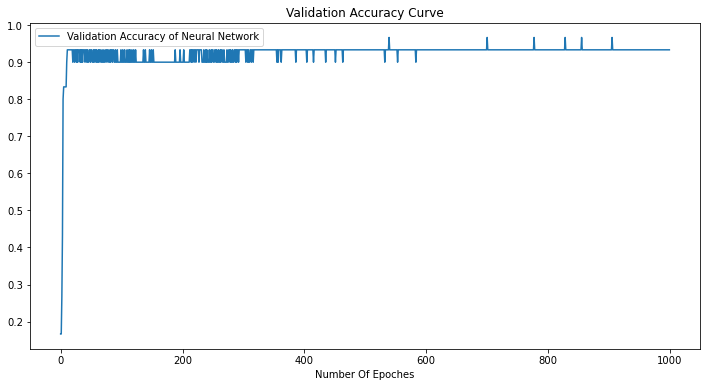

In [29]:
plt.figure(figsize=(12,6))
plt.plot(acl1,label='Validation Accuracy of Neural Network')
plt.xlabel('Number Of Epoches')
plt.title("Validation Accuracy Curve")
plt.legend()

In [30]:
trail_test = np.array([4.6,3.1,1.5,0.2],dtype='float32').reshape(-1,1)
trail_test = trail_test.reshape(1,-1)
trail_test = torch.from_numpy(trail_test)

In [31]:
p1 = Sm(trail_test)
p2 = neural(trail_test)
_, p1 = torch.max(p1.data, 1)
_, p2 = torch.max(p2.data, 1)
print("THE PREDICTION BY SIMPLE MODEL IS: ",p1)
print("")
print("THE PREDICTION BY NEURAL NETWORK IS: ",p2)

THE PREDICTION BY SIMPLE MODEL IS:  tensor([0])

THE PREDICTION BY NEURAL NETWORK IS:  tensor([0])
